The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'torch.nn.modules.batchnorm.BatchNorm1d'> 128 9 4 2 1 0 SELU()


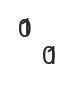

In [6]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150

sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.conv_models import CNNVAE, TwoStageCNNVAECLF
from src.metrics import reconstruction_accuracy, compute_cosine_distance
from src.cluster_utils import *
from src.networkx_utils import *
%mkdir -p ../output/240820_HumanRepertoires/heatmaps/
import csv
model_ts128 = load_model_full('../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/epoch_5000_interval_checkpoint__kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj.pt',
                              '../output/240618_NestedKCV_CNNVAE/Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj/checkpoint_best_kcv_fold_00_Nested_TwoStageCNNVAE_latent_128_kld_1e-2_ExpData_KFold_0_240618_1608_pDQhj_JSON_kwargs.json',
                              map_location='cpu', verbose=False)
metadf = pd.read_csv('../data/OTS/human/METADATA.txt')
metadf.sample(3)
def get_metadata(filename):
    # Initialize a dictionary to hold the header information
    metadatares = {'filename':os.path.basename(filename)}
    metadatares['relpath']=filename
    # Read the CSV file
    with open(filename, mode='r') as file:
        reader = csv.reader(file)
        # Read the first line which contains the metadata
        metadata_line = next(reader)[0]
        # Convert the metadata line to a dictionary
        metadata = eval(metadata_line)
    metadatares.update(metadata)
    return metadatares
    
def read_ots_data(filename):
    metadata = get_metadata(filename)
    df = pd.read_csv(filename, skiprows=1)
    df = df[[c for c in df.columns if ('aa' in c.lower() and 'cdr' in c.lower()) or 'call' in c.lower()]]
    df.columns = [x.replace('cdr','').replace('_aa_','').replace('beta','B').replace('alpha','A')[::-1] if 'cdr' in x else x for x in df.columns]
    df.columns = df.columns.str.replace('_call','')
    df['Link']=metadata['Link']
    df['Disease']=metadata['Disease']
    df['CancerType']=metadata['CancerType']
    df['Source']=metadata['TSource']
    df['Subject']=metadata['Subject']
    return df, metadata


def plot_prune_heatmap(values, threshold, title, 
                       filename=None, outdir='../output/240618_NestedKCV_CNNVAE/notebook_figs/',
                       sorted_dm=None,
                       cmap='vlag', color='g', addline=True):
    # prune and plot the heatmap
    f,ax = plt.subplots(1,2, figsize=(16,16), width_ratios=(16.5/17, 0.5/17))
    ax = ax.ravel()
    ax, cbar_ax = ax[0], ax[1]
    pruned = values.copy()
    mask = (pruned<=threshold).astype(int)
    pruned = pruned * mask
    sns.heatmap(pruned, ax=ax, square=True, vmin=0, vmax=values.max(), cbar_ax=cbar_ax, cmap=cmap)
    # Set up custom tickmarks if available
    if sorted_dm is not None:
        pepmap = sorted_dm.groupby('peptide').agg(count=('raw_index','count'))
        pepmap['idx']=pepmap['count'].cumsum()
        pepmap['tick']=pepmap['idx']-pepmap['count'].iloc[0]+3
        tickmarks = pepmap['tick'].to_dict() 
        idxs = pepmap['idx'].to_dict()
        ax.set_xticks(list(tickmarks.values()))
        ax.set_yticks(list(tickmarks.values()))
        ax.set_xticklabels(list(tickmarks.keys()), ha='center', fontweight='semibold', fontsize=15)
        ax.set_yticklabels(list(tickmarks.keys()), va='center', fontweight='semibold', fontsize=15)
    if addline and sorted_dm is not None:
        for k,v in idxs.items():
            ax.axhline(v, ls='--', lw=.9, c=color)
            ax.axvline(v, ls='--', lw=.9, c=color)
    # Rotate the tick labels for better readability (optional)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    ax.set_title(title, fontweight='semibold', fontsize=17)
    f.tight_layout()
    if filename is not None:
        f.savefig(f'{outdir}{filename}.png', dpi=150, bbox_inches='tight')
    plt.close()
    del f, ax

def do_all(filename, model, noplot=False, unique=False, outdir='../output/240820_HumanRepertoires/'):
    df, metadata = read_ots_data(filename)
    df['tcr'] = df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
    if unique:
        df.drop_duplicates(subset=['tcr'], inplace=True)
    metadata['n_seq'] = len(df)
    metadata['n_unique'] = len(df['tcr'].unique())
    pd.DataFrame(metadata, index=[0]).to_csv(f"{outdir}metadata/{metadata['Run']}_metadata.txt", index=False)
    if noplot:
        return 0
    else:
            
        if len(glob.glob(f'{outdir}heatmaps/*{metadata["Run"]}*'))>0:
            return 0
    
        latent_df = get_latent_df(model, df)
        latent_df['index_col'] = [f'seq_{i:04}' for i in range(len(latent_df))]
        _, values_array, _, _, _, _ = get_distances_labels_from_latent(latent_df, 
                                                                       label_col='Disease', 
                                                                       index_col='index_col',
                                                                       rest_cols=['Disease','CancerType','Source'],
                                                                       low_memory=True)
        
        latent_df['tcr'] = latent_df[['A1','A2','A3','B1','B2','B3']].sum(axis=1)
        n_seq=len(latent_df)
        n_unique=len(latent_df['tcr'].unique())
        plot_prune_heatmap(values_array, threshold=10, title=f"{metadata['Run']}, n_seq={n_seq}, n_unique={n_unique}", 
                           filename=f'{metadata["Run"]}_n-{n_seq}_unique-{n_unique}',
                           outdir=f'{outdir}heatmaps/', addline=False, sorted_dm=None)
        print(metadata['Run'], '\t', n_seq, '\t', n_unique)
        del latent_df
    # latent_df.groupby(['tcr']).agg(count=('B1','count')).sort_values('count',ascending=False)
x=glob.glob('../data/OTS/human/*.csv')[0]  

In [2]:
for x in tqdm(glob.glob('../data/OTS/human/*.csv')):
    do_all(x, model_ts128)

  0%|          | 0/275 [00:00<?, ?it/s]

SRR25409228 	 7169 	 1557
SRR16868435 	 687 	 517
SRR12164408 	 3083 	 542
SRR15178177 	 705 	 34
SRR25409185 	 6168 	 1496
SRR15178311 	 1398 	 339
SRR25409138 	 3635 	 1111
SRR16868450 	 3835 	 1734
SRR16868488 	 2026 	 575
SRR16868548 	 350 	 217
SRR12164396 	 10028 	 1043
SRR16868471 	 929 	 151
SRR16868497 	 5288 	 2173
SRR25409127 	 3345 	 1029
SRR15178209 	 2809 	 700
SRR25410127 	 4828 	 2365
SRR25410119 	 5092 	 2744
SRR15178156 	 1034 	 14
SRR12164429 	 3700 	 958
SRR12164417 	 3486 	 467


In [7]:
for x in tqdm(glob.glob('../data/OTS/human/*.csv')):
    do_all(x, model_ts128, noplot=True)

  0%|          | 0/275 [00:00<?, ?it/s]

In [6]:
for x in tqdm(glob.glob('../data/OTS/human/*.csv')):
    do_all(x, model_ts128, unique=True, outdir='../output/240820_HumanRepertoires/unique/')

  0%|          | 0/275 [00:00<?, ?it/s]

SRR25409170 	 1599 	 1599
SRR25410115 	 2614 	 2614
SRR16868544 	 1182 	 1182
SRR16868443 	 454 	 454
SRR25409115 	 1176 	 1176
SRR25409230 	 1495 	 1495
SRR16868484 	 299 	 299
SRR21907670 	 4106 	 4106
SRR16868462 	 292 	 292
SRR14312119 	 187 	 187
SRR16868439 	 1435 	 1435
SRR16868500 	 1014 	 1014
SRR15178299 	 21 	 21
SRR16868476 	 1787 	 1787
SRR16868448 	 760 	 760
SRR16868490 	 227 	 227
SRR25409120 	 1434 	 1434
SRR21497501 	 50 	 50
SRR15178309 	 353 	 353
SRR15178337 	 8 	 8
SRR15178255 	 325 	 325
SRR15178189 	 12 	 12
SRR25410120 	 2359 	 2359
SRR16868432 	 387 	 387
SRR25409164 	 1642 	 1642
SRR25409182 	 1562 	 1562
SRR15178211 	 689 	 689
SRR16868469 	 578 	 578
SRR16868457 	 183 	 183
SRR16868550 	 458 	 458
SRR25409186 	 1482 	 1482
SRR16868436 	 278 	 278
SRR16868453 	 433 	 433
SRR15178333 	 160 	 160
SRR25409220 	 1508 	 1508
SRR25409124 	 1274 	 1274
SRR16868472 	 484 	 484
SRR16868494 	 78 	 78
SRR16868429 	 210 	 210
SRR12164414 	 683 	 683
SRR25410124 	 2476 	

In [12]:
metadf = pd.concat([pd.read_csv(x) for x in glob.glob('../output/240820_HumanRepertoires/metadata/*')])
metadf.to_csv('../data/OTS/human/METADATA.txt', index=False)